In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

## Data Entry
### (To-Do: Create CLI after code backtested and finalized)

In [8]:
# Import user inputs
%store -r ticker
%store -r start_date
%store -r end_date
%store -r short_window
%store -r long_window

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Step 1: Define the strategy

In [9]:
# Define SMA

def SMA(data, window):
    return data.rolling(window=window).mean()

def SMA_crossover_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['short_SMA'] = SMA(data['Close'], short_window)
    signals['long_SMA'] = SMA(data['Close'], long_window)
    signals['signal'] = 0.0

    signals['signal'][short_window:] = np.where(signals['short_SMA'][short_window:] > signals['long_SMA'][short_window:], 1.0, 0.0)

    signals['positions'] = signals['signal'].diff()

    return signals

# Step 2: Plot the strategy

In [10]:
# Create dataframe of strategy
signals = SMA_crossover_strategy(data, short_window, long_window)
signals.head(150)

,price,short_SMA,long_SMA,signal,positions
Date,,,,,
2020-01-02,324.869995,NaN,NaN,0.0,NaN
2020-01-03,322.410004,NaN,NaN,0.0,0.0
2020-01-06,323.640015,NaN,NaN,0.0,0.0
2020-01-07,322.730011,NaN,NaN,0.0,0.0
2020-01-08,324.450012,NaN,NaN,0.0,0.0
...,...,...,...,...,...
2020-07-30,323.959991,323.522000,316.024999,1.0,0.0
2020-07-31,326.519989,324.001999,316.516332,1.0,0.0
2020-08-03,328.790009,324.448999,317.187998,1.0,0.0


In [11]:
# Filter the DataFrame to show only the rows with buy or sell signals
signal_data = signals.loc[signals['positions'].abs() == 1]

# Display the resulting DataFrame
print(signal_data)


                 price   short_SMA    long_SMA  signal  positions
Date                                                             
2020-02-13  337.059998  331.837003  328.770336     1.0        1.0
2020-02-27  297.510010  326.424005  328.814336     0.0       -1.0
2020-04-14  283.790009  264.559001  263.472333     1.0        1.0
2020-07-02  312.230011  307.836996  308.211996     0.0       -1.0
2020-07-10  317.589996  311.459995  310.981329     1.0        1.0
2020-09-17  335.839996  338.220004  340.508335     0.0       -1.0
2020-10-09  346.850006  337.841003  337.786336     1.0        1.0
2020-11-02  330.200012  336.749005  337.945337     0.0       -1.0
2020-11-11  356.670013  343.196005  342.566003     1.0        1.0
2021-03-05  383.630005  384.685999  385.106334     0.0       -1.0
2021-03-17  397.260010  389.597003  388.596000     1.0        1.0
2021-05-19  410.859985  414.392996  414.831330     0.0       -1.0
2021-05-27  419.290009  416.088998  415.969998     1.0        1.0
2021-09-20

In [12]:
def plot_signals(data, signals):
    fig, ax = plt.subplots()

    ax.plot(data.index, data['Close'], label='Price')
    ax.plot(data.index, signals['short_SMA'], label='Short SMA')
    ax.plot(data.index, signals['long_SMA'], label='Long SMA')

    ax.plot(signals.loc[signals.positions == 1.0].index, signals.short_SMA[signals.positions == 1.0], '^', markersize=10, color='g', label='Buy')
    ax.plot(signals.loc[signals.positions == -1.0].index, signals.short_SMA[signals.positions == -1.0], 'v', markersize=10, color='r', label='Sell')

    ax.legend(loc='best')
    plt.show()



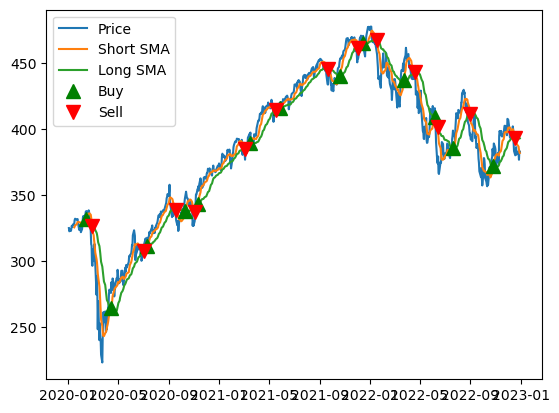

In [13]:
# Plot the signals on a chart
plot_signals(data, signals)

# Step 3: Measure Returns

In [14]:
# Calculate daily returns
signals['daily_returns'] = signals['price'].pct_change()

# Calculate daily returns when following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Filter out the periods when not holding the stock (strategy_returns == 0)
holding_returns = signals[signals['strategy_returns'] != 0]['strategy_returns']
cumulative_strategy_returns = (1 + holding_returns).cumprod()

print(cumulative_strategy_returns)


Date
2020-01-02         NaN
2020-02-14    1.001602
2020-02-18    0.999021
2020-02-19    1.003798
2020-02-20    0.999674
                ...   
2022-12-13    1.036571
2022-12-14    1.029944
2022-12-15    1.004750
2022-12-16    0.988349
2022-12-19    0.979968
Name: strategy_returns, Length: 472, dtype: float64


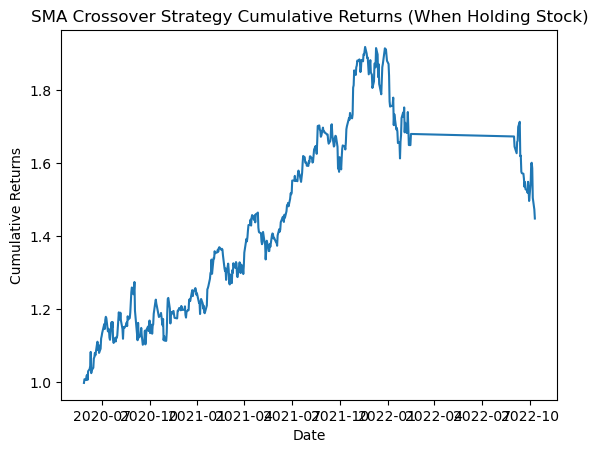

In [10]:
# Plot the cumulative returns of the strategy
plt.plot(holding_returns.index, cumulative_strategy_returns)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("SMA Crossover Strategy Cumulative Returns (When Holding Stock)")
plt.show()

# Step 4: Compare Returns

In [11]:
# Calculate cumulative returns for buy-and-hold strategy
buy_and_hold_cumulative_returns = (1 + signals['daily_returns']).cumprod()
buy_and_hold_cumulative_returns

Date
2020-01-02         NaN
2020-01-03    0.987548
2020-01-06    0.990101
2020-01-07    0.981073
2020-01-08    0.996700
                ...   
2022-12-23    1.486303
2022-12-27    1.475283
2022-12-28    1.460154
2022-12-29    1.500498
2022-12-30    1.493089
Name: daily_returns, Length: 756, dtype: float64

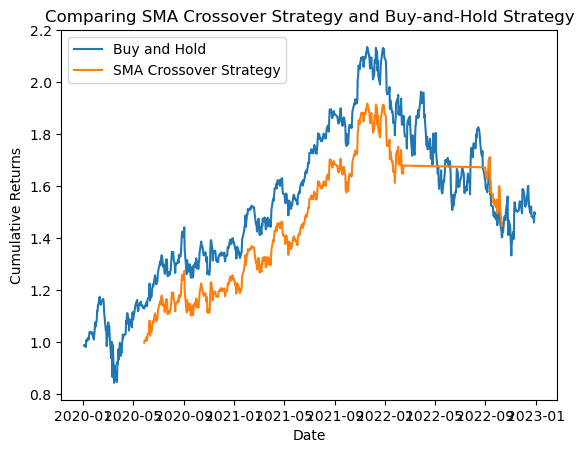

In [12]:
# Plot the cumulative returns for both strategies
plt.plot(buy_and_hold_cumulative_returns, label="Buy and Hold")
plt.plot(holding_returns.index, cumulative_strategy_returns, label="SMA Crossover Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparing SMA Crossover Strategy and Buy-and-Hold Strategy")
plt.legend()
plt.show()

# Step 5: Compare Risk

###  Crossover Strategy Volatility

In [22]:
# Calculate the annualized volatility
annualized_volatility_SMA = holding_returns.std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", holding_returns.std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility_SMA)

Standard Deviation: 0.01647063131349135
Annualized Volatility: 0.26146316635038747


### Buy and Hold Volatility

In [25]:
# Calculate the annualized volatility
annualized_volatility = signals['daily_returns'].std() * np.sqrt(252)

# Print the standard deviation
print("Standard Deviation:", signals['daily_returns'].std())

# Print the annualized volatility
print("Annualized Volatility:", annualized_volatility)

Standard Deviation: 0.021904354201893086
Annualized Volatility: 0.34772084308609086


### Sharpe Ratio

In [27]:
# Calculate the Sharpe Ratio

# Calculate daily returns when holding the stock following the crossover strategy
signals['strategy_returns'] = signals['daily_returns'] * signals['signal'].shift(1)

# Calculate the average daily returns
average_daily_returns = signals['daily_returns'].mean()
average_strategy_returns = signals['strategy_returns'].mean()

# Calculate the standard deviation of daily returns (volatility)
volatility_daily_returns = signals['daily_returns'].std()
volatility_strategy_returns = signals['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sharpe ratios
sharpe_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / volatility_daily_returns
sharpe_ratio_strategy = (average_strategy_returns - risk_free_rate) / volatility_strategy_returns

# Print the Sharpe ratios
print("Sharpe Ratio (Buy and Hold):", sharpe_ratio_buy_and_hold)
print("Sharpe Ratio (SMA Crossover Strategy):", sharpe_ratio_strategy)


Sharpe Ratio (Buy and Hold): 0.03157404683732348
Sharpe Ratio (SMA Crossover Strategy): 0.03845639310523677


### Sortino Ratio

In [31]:
# Calculate the Sortino Ratio

# Calculate the downside deviations (considering only negative returns)
downside_deviation_daily_returns = signals[signals['daily_returns'] < 0]['daily_returns'].std()
downside_deviation_strategy_returns = signals[signals['strategy_returns'] < 0]['strategy_returns'].std()

# Set the risk-free rate (e.g., the 3-month Treasury bill rate)
risk_free_rate = 0.02 / 252  # Assume an annual risk-free rate of 2% and divide by 252 trading days

# Calculate the Sortino ratios
sortino_ratio_buy_and_hold = (average_daily_returns - risk_free_rate) / downside_deviation_daily_returns
sortino_ratio_strategy = (average_strategy_returns - risk_free_rate) / downside_deviation_strategy_returns

# Print the Sortino ratios
print("Sortino Ratio (Buy and Hold):", sortino_ratio_buy_and_hold)
print("Sortino Ratio (SMA Crossover Strategy):", sortino_ratio_strategy)


Sortino Ratio (Buy and Hold): 0.04402057929044208
Sortino Ratio (SMA Crossover Strategy): 0.041299991545134446


### Maximum Drawdown

In [37]:
# Drop rows with missing or invalid values
signals.dropna(inplace=True)

# Calculate the running maximum cumulative returns
signals['running_max_bh'] = signals['buy_and_hold_cumulative_returns'].cummax()
signals['running_max_strategy'] = signals['strategy_cumulative_returns'].cummax()

# Check for any negative or zero values in the running maximum cumulative returns
print("Negative or zero values in 'running_max_bh':\n", signals[signals['running_max_bh'] <= 0])
print("Negative or zero values in 'running_max_strategy':\n", signals[signals['running_max_strategy'] <= 0])

# Calculate the drawdown for each time step
signals['drawdown_bh'] = signals['buy_and_hold_cumulative_returns'] / signals['running_max_bh'] - 1
signals['drawdown_strategy'] = signals['strategy_cumulative_returns'] / signals['running_max_strategy'] - 1

# Find the maximum drawdown for each strategy
max_drawdown_buy_and_hold = signals['drawdown_bh'].min()
max_drawdown_strategy = signals['drawdown_strategy'].min()

# Print the maximum drawdowns
print("Maximum Drawdown (Buy and Hold):", max_drawdown_buy_and_hold)
print("Maximum Drawdown (SMA Crossover Strategy):", max_drawdown_strategy)


Negative or zero values in 'running_max_bh':
 Empty DataFrame
Columns: [price, short_SMA, long_SMA, signal, positions, daily_returns, strategy_returns, buy_and_hold_cumulative_returns, strategy_cumulative_returns, running_max_bh, running_max_strategy, drawdown_bh, drawdown_strategy]
Index: []
Negative or zero values in 'running_max_strategy':
                  price  short_SMA  long_SMA  signal  positions  daily_returns  \
Date                                                                            
2020-05-28  181.399994   169.7776  168.9003     1.0        0.0      -0.002255   

            strategy_returns  buy_and_hold_cumulative_returns  \
Date                                                            
2020-05-28         -0.002255                         0.129374   

            strategy_cumulative_returns  running_max_bh  running_max_strategy  \
Date                                                                            
2020-05-28                    -0.002255        0.129

# Step 5: Example starting with $10,000

In [ ]:
#(James to adapt the code to allow the user to choose the ticker, time frame, start date and long and short crossovers)

# Backtesting function
def backtest(signals, stock_data, initial_capital=10000):
    positions = pd.DataFrame(index=signals.index).fillna(0)
    positions['stock'] = signals['position'] * stock_data['Close']
    portfolio = positions.multiply(stock_data['Close'], axis=0)
    pos_diff = positions.diff()
    portfolio['holdings'] = (positions.multiply(stock_data['Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(stock_data['Close'], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

# Execute the chosen EMA crossover strategy and plot the results
if strategy_choice == "1":
    signals = day_trader_strategy(ticker)
    stock_data = yf.download(ticker, period="1d", interval="5m")
elif strategy_choice == "2":
    signals = swing_trader_strategy(ticker)
    stock_data = yf.download(ticker, period="1y", interval="1d")
elif strategy_choice == "3":
    signals = long_term_trader_strategy(ticker)
    stock_data = yf.download(ticker, period="5y", interval="1d")
else:
    print("Invalid strategy choice.")
    stock_data = None
    
# Perform backtesting and print the results
if stock_data is not None:
    print(signals)
    portfolio = backtest(signals, stock_data)
    print("\nBacktesting Results:")
    print(portfolio)
    
# Re-enable SettingWithCopyWarning
pd.options.mode.chained_assignment = 'warn'